# CW1: Machine Learning Coursework Part 1

## 1. Importing the Libraries

In [1]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets # import datasets
import numpy as np # import numpy
import pandas as pd
import matplotlib.pyplot as plt # import plots
from math import sqrt, pow
import warnings 
warnings.filterwarnings('ignore')

## 1.1 Importing the data

In [2]:
mySeed=1234567
iris = datasets.load_iris() 
X = iris.data # get features
y = iris.target # get targets

## 2. Exploratory Data Analysis 

### 2.1 Clean Data

In [3]:
def myplotGrid(X,y):
    """Iterates over length of the number of features(4).Create scatters plots when
       i is different than j. If i is equal to j ((0,0),(1,1),(2,2),(3,3)) create a hist
       Set the x_label in the last row -> ((3,0),(3,1),(3,2),(3,3))
       Set the y_label if j is 0 -> ((0,0), (1,0), (2,0),(3,0))
        
    """
    subPlot_count = 1
    feature_length  = len(iris.feature_names)
    fig = plt.figure(figsize=(12,12))
    for i in range(feature_length):
        for j in range(feature_length):
            ax = fig.add_subplot(feature_length,feature_length, subPlot_count)
            if i == feature_length-1:
                ax.set_xlabel(iris.feature_names[j])
            if j == 0:
                ax.set_ylabel(iris.feature_names[i])
            
            if i != j:
                ax.scatter(X[:, i], X[:, j], c=y, 
                       cmap=plt.cm.Paired)
            else:
                ax.hist(X[:,j])
                
            subPlot_count += 1

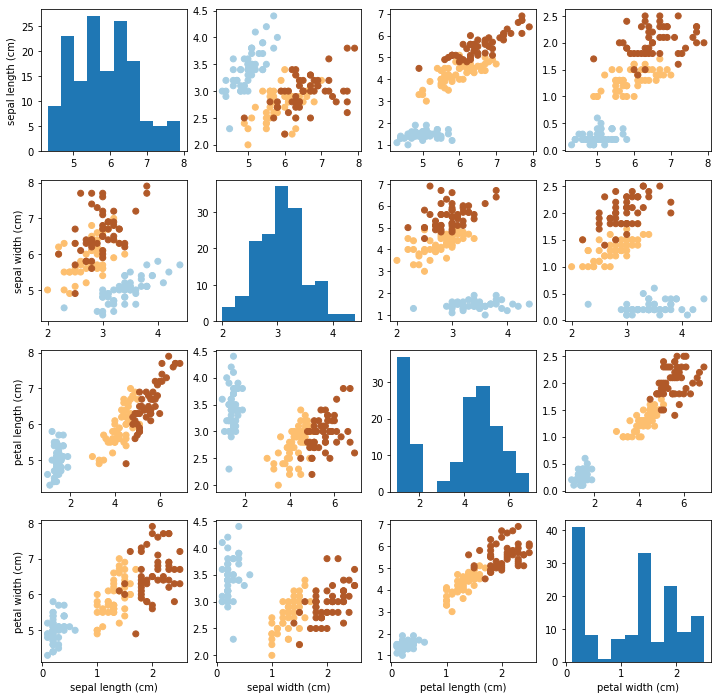

In [4]:
myplotGrid(X,y) 

### 2.2 Noisy Data



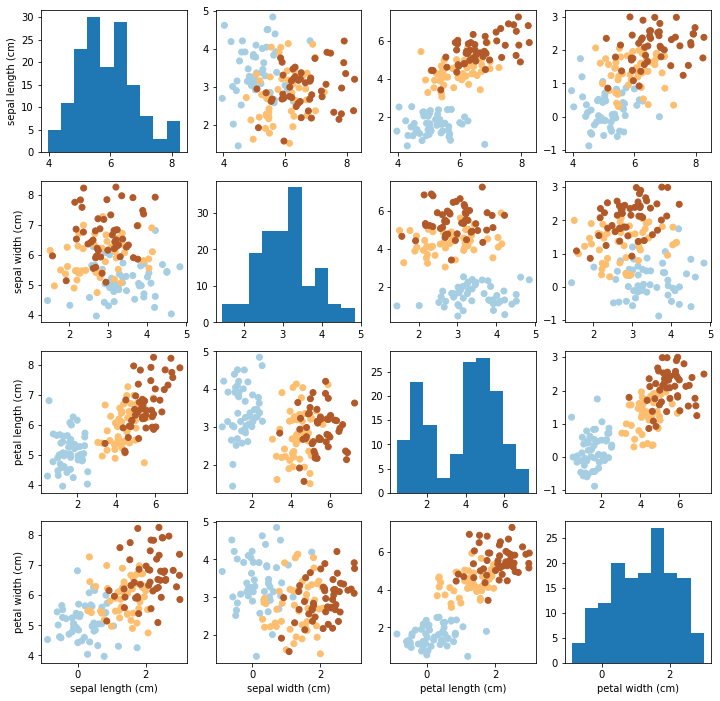

In [5]:
np.random.seed(mySeed) 
XN=X+np.random.normal(0,0.5,X.shape)
myplotGrid(XN,y)

## 3. Implementing kNN


### 3.1 Distance Metrics

<b> Note: I only became aware that the Minkowski distance is a generalization of Euclidean 
and Manhattan distance metrics after implementing the said metrics. 
Therefore, the “order” or “p“, that allows different distance metrics to be calculated will  be set to 3 by default</b>

In [6]:
def euclideanDistance(vector1,vector2):
    """Returns the squared difference between two points"""
    distance = 0
    for v1,v2 in zip(vector1,vector2):
        distance += pow((v1 - v2),2)
    return sqrt(distance)

def manhattanDistance(vector1,vector2):
    """Returns the absolute value between two points"""
    distance = 0
    for v1,v2 in zip(vector1, vector2):
        distance += abs(v1 - v2)
    return distance

def minkowskiDistance(vector1, vector2, p=3):
    """Generalization of the the euclidean/manhattan Distance, 
        where p=1 equals euclidean and p=2 equals manhattan"""
    distance = 0
    for v1,v2 in zip(vector1,vector2):
        distance += pow(abs(v1 - v2),p)
    return pow(distance,1/p)


### 3.2 Get nearest Neighbors 

In [7]:
def getNeighbours(X, X_,num_neighbors, metric):
    """Get the distance between the training data and the testing data 
        returns a sorted list indices of the k-nearest neighbors"""
    distances = list()
    neighbors = list()
    distance_measures = {"euclidean": euclideanDistance, "manhattan" : manhattanDistance,
                "minkowski": minkowskiDistance}

    for row in range(len(X)):
        dist = distance_measures[metric](X_, X[row])
        distances.append((row,dist))
           
    distances.sort(key=lambda tup: tup[1])
    
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

### 3.3 Assigning Labels

In [8]:
def assignLabel(nLabels, indices):
    """Takes a list of indices and return a predicted class based on the 
       k-nearest neighbors """
    if len(indices) == 1:
        return nLabels[indices]
    else:
        classes = np.array(nLabels[indices])
        unique, count = np.unique(classes, return_counts=True)
        values = dict(zip(unique,count))
        sorted_values = sorted(values.items(), key=lambda key: key[1], reverse=True)
    
    return sorted_values[0][0]

### 3.5 Knn

In [9]:
def mykNN(X, y, X_, num_neighbors, metric=None):
    """Gets the indices of the nearest neighbors from the getNeighbors function
       Assign the labels to the majority class, returns the predicted class 
    """
    predictions = list()
    for test_point in X_:
        neighbors = getNeighbours(X,test_point, num_neighbors, metric) 
        labels = assignLabel(y, neighbors )
        predictions.append(labels)
    return predictions
    

## 4. Evaluation functions

In [10]:
def myConfMat(y_test,y_pred,classno):
    """Intantiates a matrix with 0's. Iterates over the labels and updates the matrix"""
    C= np.zeros([classno,classno], dtype=int)
    for test, pred in zip(y_test, y_pred):
        C[test][pred] += 1  
    return C

def myAccuracy(y_test,y_pred):
    """Iterates over the labels and if they match, increase the accuracy by 1 and return
       the average 
    """
    accuracy = 0
    for test,pred in zip(y_test,y_pred):
        if test == pred:
            accuracy += 1         
    return  accuracy / len(y_pred) * 100 

def myPrecision(y_test,y_pred):
    """Instantias a new matrix, get the tp -> diagonal [i][i] = 0,0, 1,1, 2,2 diagonal
    precision = true positives / true positive + false positive  
    """
    matrix = myConfMat(y_test, y_pred, len(np.unique(y)))
    tp = [matrix[i][i] for i in np.unique(y_pred)] 
    precision = tp / matrix.sum(axis=0)
    return precision

def myRecall(y_test,y_pred):
    """Instantias a new matrix, get the tp -> diagonal [i][i] = 0,0, 1,1, 2,2 diagonal
    recall = true positives / true positive + false negative  
    """
    matrix = myConfMat(y_test, y_pred, len(np.unique(y)))
    tp = [matrix[i][i] for i in np.unique(y_pred)]
    recall = tp / matrix.sum(axis=1)
    return recall


## 5. Nested Cross-validation using your implementation of KNN



### 5.1 Nested Cross Validation

In [11]:
def myNestedCrossVal(X,y,foldK,num_neighbors,dists, mySeed):
    """Takes Training/labels,number of folds, distance measure 
       Shuffles and splits the data into 5 folds, leaving 3/5 for the training data, 1/5 for testing 
       and 1/5 validation. Get the predicted labels (y_) from the myKNN function on the validation data
       Get the best parameters after each fold on the validation data. Use the best
       parameters in the testing data. Get the precision and recall and confusion matrix
       of each fold in the testing set. 
    """
    np.random.seed(mySeed)   
    accuracy_fold = list()
    best_parameters_fold = list()
    confusion_matrices_fold = list()
    indices = list(range(X.shape[0])) 
    indices = np.random.permutation(indices)
    bins = np.array_split(indices,foldK)

    for i in range(0,foldK):
        foldTrain=[] 
        foldTest=[] 
        foldVal=[]
        
        print("Current Fold: {}\n".format(i))
        for j in range(0, foldK):
            if i == j:
                foldTest.extend(bins[j])
            #  Cyclic iteration describes a type of iteration that will 
            # reset once it gets to a certain point. Generally, this type of 
            # iteration is used to restrict the index of the iteration to a certain
            # range.               
            elif j == (i + 1)% foldK:
                foldVal.extend(bins[j])
            else:
                foldTrain.extend(bins[j])
                
        assert not np.intersect1d(foldTest,foldVal)
        assert not np.intersect1d(foldTrain,foldTest)
        assert not np.intersect1d(foldTrain,foldVal)
        
        bestDistance=''
        bestNN=-1 
        bestAccuracy=-10 
        
        for distance in dists:
            for neighbors in num_neighbors:
                # Use X[foldVal] instead of X[foldTrain]
                y_pred= mykNN(X[foldTrain], y[foldTrain], X[foldVal], neighbors, distance)
                
                currentAccuracy = myAccuracy(y[foldVal], y_pred)
                
                print("Current Distance: {d}, Current Neighbors: {n}, Accuracy: {ac}"\
                     .format(d=distance, n=neighbors, ac=currentAccuracy))
                
                if currentAccuracy > bestAccuracy:
                    bestNN = neighbors
                    bestDistance = distance
                    bestAccuracy = currentAccuracy

        print("\nValidation Set {}".format(i))
        print("Best Parameters for fold {i} Best Num_Neighbors: {bestNN},\
              Best Distance: {bestDistance} Best Accuracy: {ac}"\
              .format(i=i,bestNN=bestNN, bestDistance=bestDistance, ac=bestAccuracy))
        
        foldTrain.extend(foldVal)     
        y_pred = mykNN(X[foldTrain], y[foldTrain], X[foldTest], bestNN, bestDistance)
        
        confMat = myConfMat(y[foldTest],y_pred, len(np.unique(y)))  
        accuracy = myAccuracy(y[foldTest],y_pred)
        precision = myPrecision(y[foldTest],y_pred)
        recall = myRecall(y[foldTest],y_pred)
        
        best_parameters_fold.append((i,accuracy , bestNN, bestDistance))
        accuracy_fold.append(myAccuracy(y[foldTest], y_pred))
        confusion_matrices_fold.append(confMat)
        print('\nTest Set {}'.format(i))
        print("Confusion Matrix: \n{cf} \nPrecision: {pr}, \nRecall: {re} \nAccuracy: \
              {acc}\n".format(cf=confMat, pr=precision, re=recall, acc=accuracy))

    return accuracy_fold, best_parameters_fold, confusion_matrices_fold;



### 5.2  Nested Cross Validation: Clean data 

In [12]:
accuracy_fold, best_parameters_fold, confusion_matrix_fold = myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan', 'minkowski'],mySeed)

Current Fold: 0

Current Distance: euclidean, Current Neighbors: 1, Accuracy: 93.33333333333333
Current Distance: euclidean, Current Neighbors: 2, Accuracy: 93.33333333333333
Current Distance: euclidean, Current Neighbors: 3, Accuracy: 96.66666666666667
Current Distance: euclidean, Current Neighbors: 4, Accuracy: 96.66666666666667
Current Distance: euclidean, Current Neighbors: 5, Accuracy: 93.33333333333333
Current Distance: euclidean, Current Neighbors: 6, Accuracy: 93.33333333333333
Current Distance: euclidean, Current Neighbors: 7, Accuracy: 93.33333333333333
Current Distance: euclidean, Current Neighbors: 8, Accuracy: 93.33333333333333
Current Distance: euclidean, Current Neighbors: 9, Accuracy: 93.33333333333333
Current Distance: euclidean, Current Neighbors: 10, Accuracy: 96.66666666666667
Current Distance: manhattan, Current Neighbors: 1, Accuracy: 93.33333333333333
Current Distance: manhattan, Current Neighbors: 2, Accuracy: 90.0
Current Distance: manhattan, Current Neighbors:

#### 5.2.1 Summary of results: Clean Data

In [13]:
df = pd.DataFrame(best_parameters_fold, 
                  columns=["Fold", "Accuracy", "Num_Neighbors", 'Distance'])
df.set_index("Fold")

,Accuracy,Num_Neighbors,Distance
Fold,,,
0,96.666667,3,euclidean
1,93.333333,4,euclidean
2,93.333333,1,euclidean
3,100.000000,4,euclidean
4,96.666667,1,euclidean


In [14]:
print("Accuracy Fold: \n{}".format(accuracy_fold))
print("Mean: {}".format(np.mean(accuracy_fold)))
print("Standard Deviation: {}".format(np.std(accuracy_fold)))

Accuracy Fold: 
[96.66666666666667, 93.33333333333333, 93.33333333333333, 100.0, 96.66666666666667]
Mean: 96.0
Standard Deviation: 2.4944382578492967


### 5.3 Nested Cross Validation: Noisy data 

In [15]:
np.random.seed(mySeed) 
sh = np.random.permutation(len(y))
new_x = XN[sh]
new_y = y[sh]

accuracy_fold_Noisy, best_parameters_fold_Noisy,\
confusion_matrix_Noisy = myNestedCrossVal(new_x,new_y,5,list(range(1,11)),['euclidean','manhattan', 'minkowski'],mySeed)

Current Fold: 0

Current Distance: euclidean, Current Neighbors: 1, Accuracy: 73.33333333333333
Current Distance: euclidean, Current Neighbors: 2, Accuracy: 83.33333333333334
Current Distance: euclidean, Current Neighbors: 3, Accuracy: 76.66666666666667
Current Distance: euclidean, Current Neighbors: 4, Accuracy: 83.33333333333334
Current Distance: euclidean, Current Neighbors: 5, Accuracy: 80.0
Current Distance: euclidean, Current Neighbors: 6, Accuracy: 86.66666666666667
Current Distance: euclidean, Current Neighbors: 7, Accuracy: 80.0
Current Distance: euclidean, Current Neighbors: 8, Accuracy: 80.0
Current Distance: euclidean, Current Neighbors: 9, Accuracy: 80.0
Current Distance: euclidean, Current Neighbors: 10, Accuracy: 83.33333333333334
Current Distance: manhattan, Current Neighbors: 1, Accuracy: 73.33333333333333
Current Distance: manhattan, Current Neighbors: 2, Accuracy: 83.33333333333334
Current Distance: manhattan, Current Neighbors: 3, Accuracy: 76.66666666666667
Current

#### 5.3.1 Summary of results: Noisy Data

In [16]:
df = pd.DataFrame(best_parameters_fold_Noisy, 
                  columns=["Fold", "Accuracy", "Num_Neighbors", 'Distance'])
df.set_index("Fold")

,Accuracy,Num_Neighbors,Distance
Fold,,,
0,96.666667,6,minkowski
1,83.333333,7,manhattan
2,86.666667,10,euclidean
3,76.666667,7,euclidean
4,86.666667,8,manhattan


In [17]:
print("Accuracy Fold: \n{}".format(accuracy_fold_Noisy))
print("Mean: {}".format(np.mean(accuracy_fold_Noisy)))
print("Standard Deviation: {}".format(np.std(accuracy_fold_Noisy)))

Accuracy Fold: 
[96.66666666666667, 83.33333333333334, 86.66666666666667, 76.66666666666667, 86.66666666666667]
Mean: 86.00000000000001
Standard Deviation: 6.463573143221772


### 6. Confusion matrix summary

<b>Note: The confusion matrix, class precision and recall of each fold on the Test set is showed above.</b>   

#### 6.1.Confusion Matrix summary: Clean Data

In [18]:
cf = sum(confusion_matrix_fold)
cols_ind = ["Class 0", "Class 1", "Class 2"]
pd.DataFrame(cf, columns=cols_ind, index=cols_ind)

,Class 0,Class 1,Class 2
Class 0,50,0,0
Class 1,0,47,3
Class 2,0,3,47


#### 6.2.Confusion Matrix summary: Noisy Data

In [19]:
cf = sum(confusion_matrix_Noisy)
cols_ind = ["Class 0", "Class 1", "Class 2"]
pd.DataFrame(cf, columns=cols_ind, index=cols_ind)

,Class 0,Class 1,Class 2
Class 0,50,0,0
Class 1,0,41,9
Class 2,0,12,38


## 7. Questions 

Now answer the following questions as fully as you can. The answers should be based on your implementation above. Write your answers in new Markdown cells below each question.

### Q1. Choice of parameters
Do the best parameters change per fold? Is there one parameter choice that is best regardless of the data used?

The nested cross validation has found the best set of parameters (<b>K</b> ,<b>distance</b>) after each fold. In the clean dataset, the Euclidean distance was chosen as the best distance measure, with the number of neighbors ranging from 1 to 4. It is important to bear in mind that the  performance each set of parameters is at the very least the same or slightly better than each other. Therefore, since  there is no tie-breaking algorithm in place, the other two measures (Manhattan and Minkowski) could have been chosen as the best distance measure, had they been passed in as the first argument. 
<br><br>
As for the noisy data, Minkowski is the least frequent and yet the most accurate distance measure. The number of neighbors now ranges between 6 and 10.
<br>
Based on the results for each dataset, it can be assumed that it is not possible to use a single set of parameters regardless of the dataset used


### Q2.	 Clean vs. noisy
Does the best parameter choice change depending on whether we use clean or noisy data? (Answer for both distance function and number of neighbours.)

Yes, the choice of the best parameter changes depending on the dataset used, however, the difference is small. In the clean dataset, the best set of parameters is the Euclidean distance with an accuracy of 100% with 4 neighbors, whereas in the noisy dataset, the best set of parameters is the Minkowski distance with an accuracy of 96% with 6 neighbors.

### Q3. Exploratory data analysis
Looking again at the exploratory data analysis, what do you observe by plotting the figure for data without noise? What do you observe when you add Gaussian noise and plot again? 

Before adding Gaussian noise, class 0 is easily distinguished from the other two classes(class 1 and class 2). The features of Class 1 and 2 are more similar, therefore making them closer to each other in the scatter plots. After adding Gaussian noise, all classes now overlap with each other and the data seems to be more spread  out.  This explains the 10% disparity in accuracy, with the clean data being on average 96% accurate, while the noisy data is only 86%.

### Q4. Tie break
Assume that you have selected the number of neighbours to be an even number, e.g., 2. For one of the neighbours, the suggested class is 1, and for the other neighbour the suggested class is 2. How would you break the tie? Write example pseudocode that does this.

One method is to pick a label among the possible choices at random
<br><br>
Pseudocode:<br>
&emsp;	If K is even:<br>
&nbsp;&nbsp;&nbsp;&nbsp;		return random(label)
<br><br>
Another method is to either decrease or increase the number of K
<br><br>
Pseudocode:<br>
if K is even:<br>
&emsp;	look for K-1 nearest neighbors:<br> 
&nbsp;&nbsp;&nbsp;&nbsp;			if tie is Broken:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;			return  Label


### Q5.	Improving performance on noisy data. 
The performance of k-NN on the noisy data should be worse than on the clean data. Suggest at least one way of improving the performance on the noisy data. Try to elaborate on your idea as much as possible, including pseudocode where possible.

One way increase the performance on the noisy data would be to increase the number of folds in the nested crossed validation
<br>
<b>Test 1: Increasing the number K</b><br>
- Increasing the number k to 15 does not seem to affect the accuracy.<br><br> 

<b>Test 2: Increasing the number of folds</b><br>
- Increasing the number of folds to 15 increases the accuracy to a up to 100%<br><br>

<b>Test 3: Increasing the number K and number of folds</b><br>
- Increasing both the number of neighbors and the number of folds to 15 does not seem to change the results in a significant way.
                                            

In [20]:
# Tests
# accuracy_fold_Noisy_Q5, best_parameters_fold_Noisy_Q5,\
# confusion_matrix_Noisy_Q5 = myNestedCrossVal(new_x,new_y,15,list(range(1,15)),['euclidean','manhattan', 'minkowski'],mySeed)
# print("Accuracy folK == 5",accuracy_fold_Noisy)
# print(accuracy_fold_Noisy_Q5)

# Bibliography

1. The get neighbors function is based on this tutorial: https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/
<br><br>
2. The confusion matrix is based on this implementation: http://www.nltk.org/_modules/nltk/metrics/confusionmatrix.html
